<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Notebook-Snapshots/RuntypeBERT/BERT_As_Embedding_Layer_2SVM_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

In [3]:
import datasets

data = datasets.load_dataset("raygx/NepCov19TweetsPlus").rename_columns({"Sentiment":"label","Sentences":"text"}).shuffle(999)['train'].train_test_split(test_size=0.2)
data


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/41541 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [4]:
def LabelEncoding(x):
    if x['label']==-1:
        x['label'] =  2
    return x

data = data.map(
        LabelEncoding,
        num_proc=2)

data['train'][:5]

Map (num_proc=2):   0%|          | 0/33232 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/8309 [00:00<?, ? examples/s]

{'label': [0, 0, 0, 0, 1],
 'text': ['बालबालिकामा कोभिड का लक्षण देखिएमा के गर्ने सफल नेपाल',
  'कोविड र सामान्य चिसोमा के गर्ने र नगर्ने बीच कसरी फरक गर्ने',
  'बैठकमा मिलेनियम च्यालेन्ज कर्पोरेशन एमसीसीको बजेट र कोभिडबारे पनि छलफल हुने अर्का स्थायी समिति सदस्य देवेन्द्र पौडेलले जानकारी दिए ।',
  'कोभिड –१९ महामारीले नेपालमा बालबालिकाको स्वास्थ्य, सिकाइ र मनोसामाजिक अवस्थालाई असर पारेको\u200d युनिसेफकाे एक अध्ययनले देखाएको छ\xa0। \u200d',
  'डब्लूएचओको प्रत्यक्ष निगरानीमा कोरोना परीक्षण कोभिड यसकारण भित्रिएको छैन नेपालमा']}

In [5]:
from transformers import TFBertForSequenceClassification, PreTrainedTokenizerFast

model_id = 'raygx/BERT-NepSA-T2' ## Fine-tuned Model for SA ## 'raygx/BertClassifier4NepaliNews' ## Fine-tuned Model for NewsClassification ## 'Shushant/nepaliBERT' ## Pre-Trained LM ##

tokenizer = PreTrainedTokenizerFast.from_pretrained(model_id)
tokenizer

try:
  model = TFBertForSequenceClassification.from_pretrained(model_id,
              id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
              label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2},ignore_mismatched_sizes=True)
except:
  model = TFBertForSequenceClassification.from_pretrained(model_id,
              id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
              label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2},ignore_mismatched_sizes=True,from_pt=True)

model.summary()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at raygx/BERT-NepSA-T2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


### Code For Using BERT as Embedding Layer

In [11]:
import tensorflow as tf

class BERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    # if x.shape[0] != None:
    #   x = [str(i) for i in x]
    # else:
    #   x = str(x)
    return self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))[1]

In [12]:
# model.bert(tokenizer('बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको',padding='max_length',truncation=True,return_tensors='tf',max_length=128))
embd = BERTEmbedding(model.bert,tokenizer,max_token_len=100)
# embd(["",'बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको','बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको'])
# embd(["abcd"])
d_model = embd(["abcd",'efgh']).shape[1]
d_model

768

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data,model_dim, batch_size=32,shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data
        self.embeddings = np.empty((data.num_rows,model_dim))
        self.shuffle = shuffle
        # self.average = tf.keras.layers.Average()
        self.is_first_epoch = True
        self.on_epoch_end(is_first_epoch=self.is_first_epoch)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.data.num_rows / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)

    def on_epoch_end(self,is_first_epoch=False):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.data.num_rows)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        self.is_first_epoch = is_first_epoch


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        chunk = self.data.select(indexes)

        if self.is_first_epoch:
          X = embd(chunk['text'])
          self.embeddings[indexes] = X
        else:
          X = self.embeddings[indexes]

        y = np.array(chunk['label'])
        return X,y

In [14]:
%%time

train_features = DataGenerator(data['train'],model_dim=d_model,batch_size=16)
test_features = DataGenerator(data['test'],model_dim=d_model,shuffle=False)

CPU times: user 1.83 ms, sys: 0 ns, total: 1.83 ms
Wall time: 2.83 ms


## Model Specification

In [34]:
sa_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(768)),
    tf.keras.layers.Dense(768,activation='gelu',name='Pooler'),
    tf.keras.layers.Dropout(0.1,name='Dropout'),
    tf.keras.layers.Dense(3,activation='softmax',name='Activation')
])

In [35]:
sa_model.compile(
  optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-4,
        weight_decay=0.004
      ),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

sa_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Pooler (Dense)              (None, 768)               590592    
                                                                 
 Dropout (Dropout)           (None, 768)               0         
                                                                 
 Activation (Dense)          (None, 3)                 2307      
                                                                 
Total params: 592,899
Trainable params: 592,899
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = sa_model.fit(train_features,
        epochs=30,
        validation_data=test_features,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss', patience=3,
                            verbose=1, mode='auto',
                            restore_best_weights=True)
                        ])

Epoch 1/30
2077/2077 [==============================] - 15s 7ms/step - loss: 0.3949 - acc: 0.8471 - val_loss: 0.5335 - val_acc: 0.7922
Epoch 2/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.3784 - acc: 0.8501 - val_loss: 0.5692 - val_acc: 0.7902
Epoch 3/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.3742 - acc: 0.8538 - val_loss: 0.5350 - val_acc: 0.7923
Epoch 4/30
2077/2077 [==============================] - 16s 8ms/step - loss: 0.3687 - acc: 0.8551 - val_loss: 0.5562 - val_acc: 0.7869
Epoch 5/30
2077/2077 [==============================] - 13s 6ms/step - loss: 0.3617 - acc: 0.8566 - val_loss: 0.5475 - val_acc: 0.7929
Epoch 6/30
2077/2077 [==============================] - 13s 6ms/step - loss: 0.3533 - acc: 0.8600 - val_loss: 0.5627 - val_acc: 0.7958
Epoch 7/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.3445 - acc: 0.8624 - val_loss: 0.5624 - val_acc: 0.7899
Epoch 8/30
2077/2077 [==============================] -

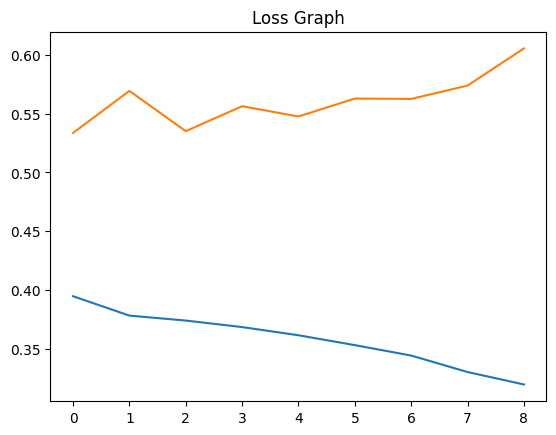

Text(0.5, 1.0, 'Accuracy Graph')

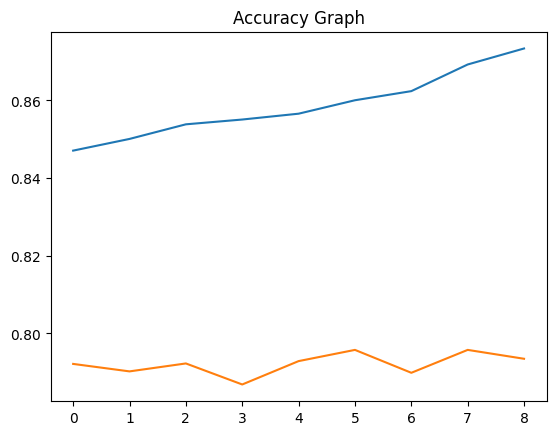

In [37]:
import seaborn
from matplotlib import pyplot as plt

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])
plt.title("Loss Graph")
plt.show()

seaborn.lineplot(history.history['acc'])
seaborn.lineplot(history.history['val_acc'])
plt.title("Accuracy Graph")

## Evaluation Section

In [38]:
%%time

print("Getting Test Prediction")
pred_labels = [np.argmax(x) for x in sa_model.predict(test_features)]
actual_labels = data['test']['label']

Getting Test Prediction
260/260 [==============================] - 1s 5ms/step
CPU times: user 1.42 s, sys: 27.8 ms, total: 1.45 s
Wall time: 2.7 s


In [39]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.7962347258514287
Precision-Score 0.8002239527896788
Recall-Score 0.7957636297990132
accuracy_Score 0.7957636297990132


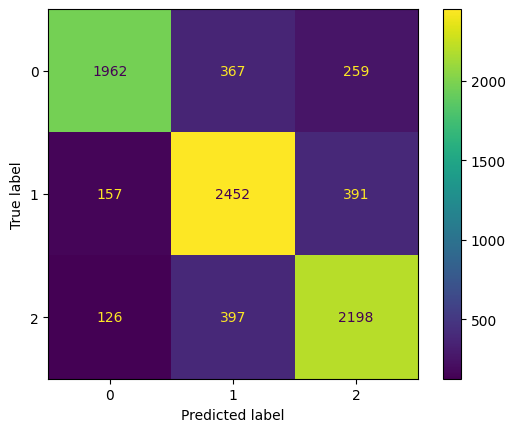

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

In [42]:
feature_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(768)),
    sa_model.get_layer('Pooler')
])

feature_model.compile(
  optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-4,
        weight_decay=0.004
      ),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

feature_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Pooler (Dense)              (None, 768)               590592    
                                                                 
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
_________________________________________________________________


## Training SVM

In [47]:
from tqdm.auto import tqdm

X = None
for x in tqdm(train_features):
  if X is None:
    X = feature_model(x[0])
  else:
    X = np.concatenate([X,feature_model(x[0])], axis=0)

X

  0%|          | 0/2077 [00:00<?, ?it/s]

array([[-1.22430196e-04, -3.16271866e-07, -7.59530754e-04, ...,
         5.37093997e-01, -3.14025528e-05, -1.62004903e-01],
       [-4.57991511e-02, -3.43510439e-03, -7.58689223e-03, ...,
        -9.63793099e-02, -2.40027462e-03,  2.67150617e+00],
       [-1.81356954e-04, -0.00000000e+00, -1.02560889e-05, ...,
         9.90300953e-01, -2.39431844e-04, -8.05374682e-02],
       ...,
       [ 4.19474155e-01, -1.69455796e-01, -1.50793329e-01, ...,
        -2.05618292e-02, -1.52515203e-01,  3.21356583e+00],
       [-1.93923886e-03, -4.66776697e-07, -7.55082851e-07, ...,
         1.46218765e+00, -1.91049526e-06, -1.15050234e-01],
       [-6.24307650e-05, -0.00000000e+00, -1.67016187e-04, ...,
        -7.42607787e-02, -6.02621867e-06, -5.27219474e-03]], dtype=float32)

In [49]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 15min 51s, sys: 1.54 s, total: 15min 52s
Wall time: 16min 33s


array([0, 1, 2])

In [50]:
from tqdm.auto import tqdm

testX  = None
for x in tqdm(test_features):
  if testX is None:
    testX  = feature_model(x[0])
  else:
    testX  = np.concatenate([testX ,feature_model(x[0])], axis=0)

testX

  0%|          | 0/260 [00:00<?, ?it/s]

array([[-1.51962170e-03, -0.00000000e+00, -1.15560964e-04, ...,
        -1.66570375e-04, -4.66451183e-07, -5.09920120e-02],
       [-1.63155550e-04, -0.00000000e+00, -4.41195880e-06, ...,
         6.09810233e-01, -4.61201381e-07, -1.00849792e-02],
       [-4.78713046e-04, -1.14728339e-01, -5.51383418e-04, ...,
        -1.49553642e-04, -4.77249923e-05, -3.95958684e-03],
       ...,
       [-8.81615233e-06, -1.55257197e-07, -7.37184928e-06, ...,
        -1.26107261e-01, -7.60316595e-07, -4.17282432e-02],
       [-1.09677116e-04, -0.00000000e+00, -1.55117192e-07, ...,
        -1.96888242e-02,  3.36217965e-07, -1.24775898e-03],
       [-2.94301481e-05, -0.00000000e+00, -2.63313314e-06, ...,
        -9.33187306e-02, -4.67897621e-07, -1.10026367e-01]], dtype=float32)

## SVM Evalutaion

In [51]:
%%time
predictions = clf.predict(testX)

CPU times: user 4min 4s, sys: 287 ms, total: 4min 5s
Wall time: 4min 5s


In [52]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.19387868170410738
Precision-Score 0.45586012210075405
Recall-Score 0.36129498134552895
accuracy_Score 0.36129498134552895


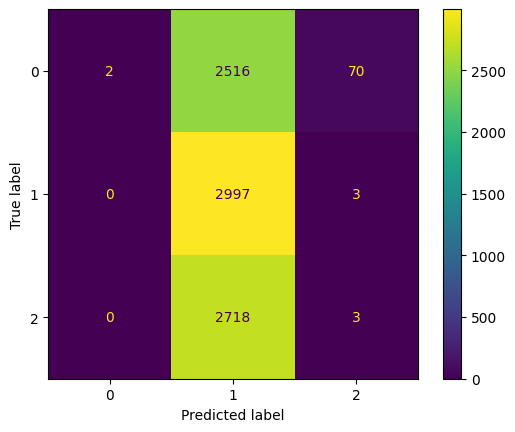

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()